<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/experiments/Memoria_experiment_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp /content/gdrive/MyDrive/methods.py .

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import methods as f

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras import layers
from tensorflow.keras import activations

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
#params
maxlen=90
batch_size = 4
embedding_dim=64
lr=0.001
epochs=40

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


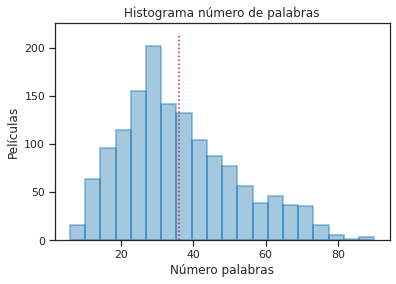

In [5]:
df = f.read_data("gdrive/My Drive/TFG/overviews_final.csv")
df['overview'] = df['overview'].progress_apply(lambda x: f.preprocessing(x))
X_train, X_test, y_train, y_test = f.split_train_test(df)
X_train, X_test, vocab_size, real_maxlen = f.tokenize(X_train, X_test, maxlen)

In [50]:
def plot_history(history, horizontal=0.35, vertical_train=0.05, vertical_val=0.06):
  fit_history = pd.DataFrame(history.history)
  fit_history['epoch'] = fit_history.index + 1
  fit_history = fit_history.round(2)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

  # Loss
  fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='.', ax=ax1)

  # Acc
  fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='.', ax=ax2)

  x = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()]

  first_max_acc = fit_history[fit_history['val_accuracy']==fit_history['val_accuracy'].max()].iloc[0]
  x = first_max_acc['epoch']
  y = first_max_acc['val_accuracy']
  z = first_max_acc['accuracy']

  ax2.text(x = x - horizontal, # x-coordinate position of data label
          y = y - vertical_val, # y-coordinate position of data label
          s = '{:.2f}'.format(y), # data label
          color = 'tab:orange') # set colour of line
  ax2.text(x = x- horizontal, # x-coordinate position of data label
          y = z - vertical_train, # y-coordinate position of data label
          s = '{:.2f}'.format(z), # data label
          color = 'tab:blue') # set colour of line

#CNN -> Resnet

Cambiamos la arquitectura CNN por dos unidades residuales

Hands on (pag 623)

In [36]:
inputs = layers.Input(shape=(maxlen,))

# Embedding
x_inp = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)

# CNN - Plain
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x_inp)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# CNN - Res 1
x_1 = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x)
x_1 = layers.BatchNormalization()(x_1)
x_1 = layers.Conv1D(32, 3, padding="same", strides=1)(x_1)
x_1 = layers.BatchNormalization()(x_1)
x_1 = layers.Add()([x, x_1])
x_1 = layers.Activation(activations.relu)(x_1)

# CNN - Res 2
x_2 = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x_1)
x_2 = layers.BatchNormalization()(x_2)
x_2 = layers.Conv1D(32, 3, padding="same", strides=1)(x_2)
x_2 = layers.BatchNormalization()(x_2)
x_2 = layers.Add()([x_1, x_2])
x_2 = layers.Activation(activations.relu)(x_2)

x_2 = layers.MaxPooling1D(pool_size=2, strides=2)(x_2)

# LSTM Bi
x = layers.Bidirectional(layers.LSTM(16))(x_2)
x = layers.BatchNormalization()(x)

# FNN
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output layer, 1 neuron with sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr, decay = lr/epochs), metrics=['accuracy'])

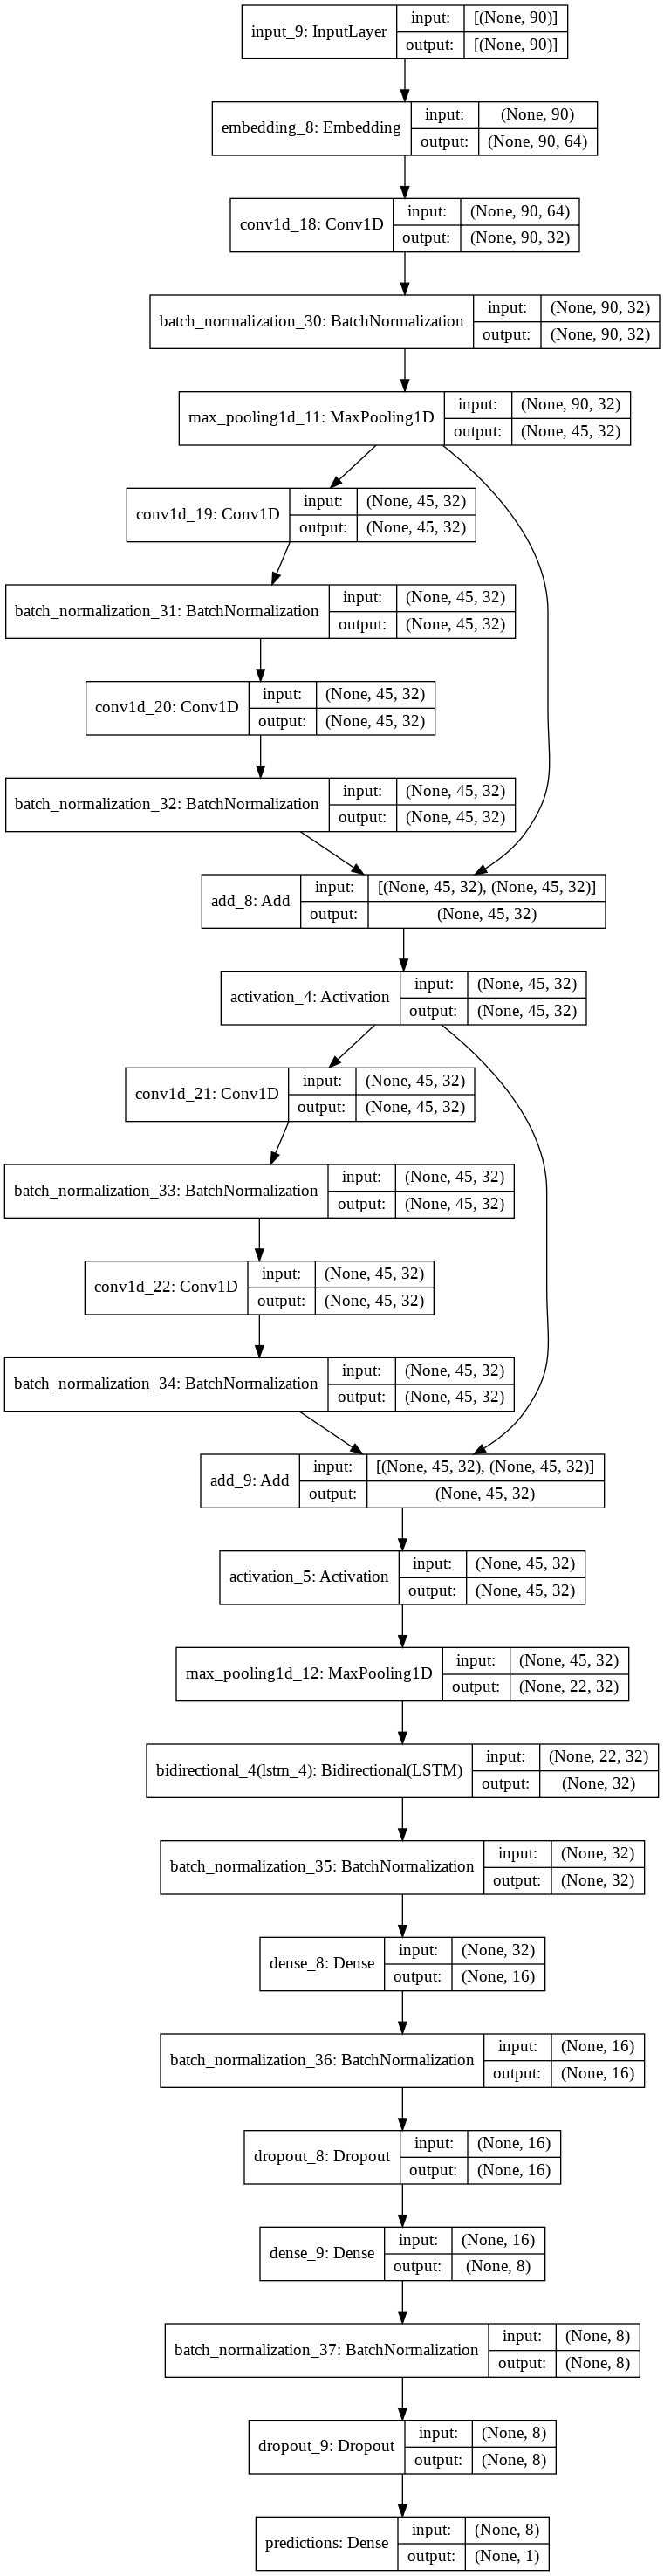

In [37]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=60,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    callbacks=[callback])

Epoch 1/60
358/358 [==============================] - 17s 31ms/step - loss: 0.8800 - accuracy: 0.4964 - val_loss: 0.9394 - val_accuracy: 0.4519
Epoch 2/60
358/358 [==============================] - 10s 28ms/step - loss: 0.7787 - accuracy: 0.4904 - val_loss: 1.0461 - val_accuracy: 0.4519
Epoch 3/60
358/358 [==============================] - 10s 28ms/step - loss: 0.7361 - accuracy: 0.5003 - val_loss: 0.8728 - val_accuracy: 0.4519
Epoch 4/60
358/358 [==============================] - 10s 28ms/step - loss: 0.7017 - accuracy: 0.5407 - val_loss: 0.6999 - val_accuracy: 0.5498
Epoch 5/60
358/358 [==============================] - 10s 28ms/step - loss: 0.6874 - accuracy: 0.5328 - val_loss: 0.7171 - val_accuracy: 0.5449
Epoch 6/60
358/358 [==============================] - 10s 28ms/step - loss: 0.6924 - accuracy: 0.5477 - val_loss: 0.6913 - val_accuracy: 0.5449
Epoch 7/60
358/358 [==============================] - 10s 28ms/step - loss: 0.6733 - accuracy: 0.5722 - val_loss: 0.6918 - val_accuracy:

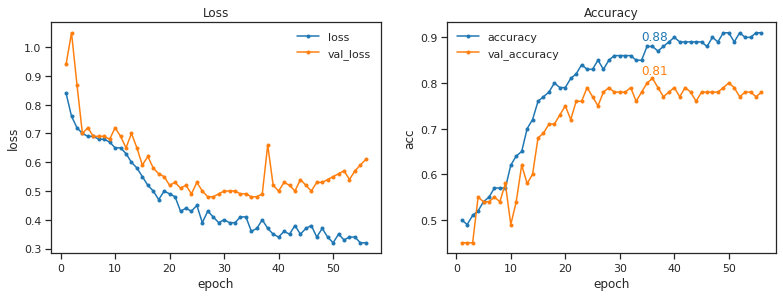

In [60]:
plot_history(history, 
             horizontal=2, 
             vertical_train=-0.015, vertical_val=-0.01)
# epoch 36

In [61]:
f.plot_metrics(model, X_test, y_test)

Acc: 0.81
Precision: 0.82
Recall: 0.75
F1: 0.79
Conf. Matrix: 
[[290  46]
 [ 68 209]]


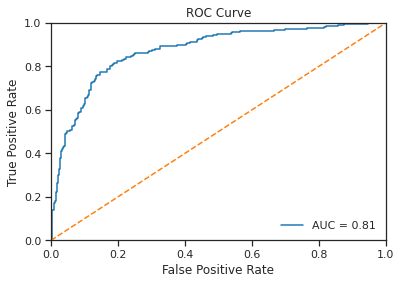

AUC: 0.8088


In [62]:
f.get_roc_curve(model, X_test, y_test)

#Bidirectional LSTM -> Bidirectional GRU

In [87]:
inputs = layers.Input(shape=(maxlen,))

# Embedding
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)

# CNN 1
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 2
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# GRU Bi
x = layers.Bidirectional(layers.GRU(16))(x)
x = layers.BatchNormalization()(x)

# FNN
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output layer, 1 neuron with sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr, decay = lr/epochs), metrics=['accuracy'])

In [88]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=80,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    callbacks=[callback])

Epoch 1/80
358/358 [==============================] - 14s 26ms/step - loss: 0.9887 - accuracy: 0.5083 - val_loss: 1.2224 - val_accuracy: 0.4519
Epoch 2/80
358/358 [==============================] - 9s 24ms/step - loss: 0.8332 - accuracy: 0.5279 - val_loss: 0.9578 - val_accuracy: 0.4502
Epoch 3/80
358/358 [==============================] - 9s 24ms/step - loss: 0.7342 - accuracy: 0.5457 - val_loss: 1.1861 - val_accuracy: 0.5498
Epoch 4/80
358/358 [==============================] - 9s 25ms/step - loss: 0.7105 - accuracy: 0.5378 - val_loss: 0.6683 - val_accuracy: 0.5905
Epoch 5/80
358/358 [==============================] - 9s 24ms/step - loss: 0.7168 - accuracy: 0.5258 - val_loss: 0.6868 - val_accuracy: 0.5595
Epoch 6/80
358/358 [==============================] - 8s 24ms/step - loss: 0.6956 - accuracy: 0.5571 - val_loss: 0.6764 - val_accuracy: 0.5612
Epoch 7/80
358/358 [==============================] - 9s 24ms/step - loss: 0.6822 - accuracy: 0.5452 - val_loss: 0.6879 - val_accuracy: 0.515

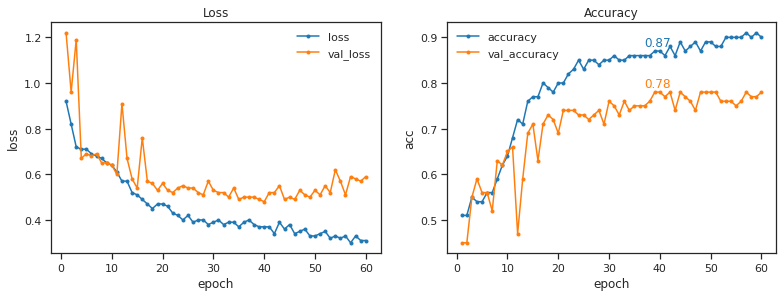

In [91]:
plot_history(history, 
             horizontal=2, 
             vertical_train=-0.01, vertical_val=-0.01)
# epoch 40

In [92]:
f.plot_metrics(model, X_test, y_test)

Acc: 0.78
Precision: 0.79
Recall: 0.71
F1: 0.75
Conf. Matrix: 
[[285  51]
 [ 81 196]]


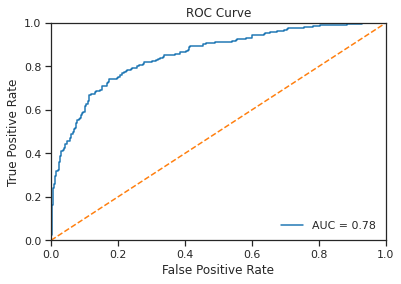

AUC: 0.7779


In [93]:
f.get_roc_curve(model, X_test, y_test)

# Bidirectional GRU -> GRU + GRU

Hands on pag 689

In [100]:
inputs = layers.Input(shape=(maxlen,))

# Embedding
x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)

# CNN 1
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# CNN 2
x = layers.Conv1D(32, 3, padding="same", activation="relu", strides=1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# GRU + GRU
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)
x = layers.BatchNormalization()(x)

# FNN
x = layers.Dense(16, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(8, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

# Output layer, 1 neuron with sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr, decay = lr/epochs), metrics=['accuracy'])

In [101]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 90)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 90, 64)            630848    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 90, 32)            6176      
_________________________________________________________________
batch_normalization_73 (Batc (None, 90, 32)            128       
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 45, 32)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 45, 32)            3104      
_________________________________________________________________
batch_normalization_74 (Batc (None, 45, 32)            128

In [95]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=80,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size,
                    callbacks=[callback])

Epoch 1/80
358/358 [==============================] - 15s 26ms/step - loss: 0.9270 - accuracy: 0.5164 - val_loss: 0.7400 - val_accuracy: 0.5563
Epoch 2/80
358/358 [==============================] - 9s 25ms/step - loss: 0.7866 - accuracy: 0.5380 - val_loss: 0.6978 - val_accuracy: 0.5334
Epoch 3/80
358/358 [==============================] - 9s 24ms/step - loss: 0.7364 - accuracy: 0.5285 - val_loss: 0.6996 - val_accuracy: 0.4747
Epoch 4/80
358/358 [==============================] - 9s 24ms/step - loss: 0.7132 - accuracy: 0.5183 - val_loss: 0.6801 - val_accuracy: 0.5546
Epoch 5/80
358/358 [==============================] - 9s 24ms/step - loss: 0.6906 - accuracy: 0.5449 - val_loss: 0.6779 - val_accuracy: 0.6052
Epoch 6/80
358/358 [==============================] - 9s 24ms/step - loss: 0.6927 - accuracy: 0.5513 - val_loss: 0.6710 - val_accuracy: 0.6069
Epoch 7/80
358/358 [==============================] - 9s 24ms/step - loss: 0.6831 - accuracy: 0.5490 - val_loss: 0.6816 - val_accuracy: 0.559

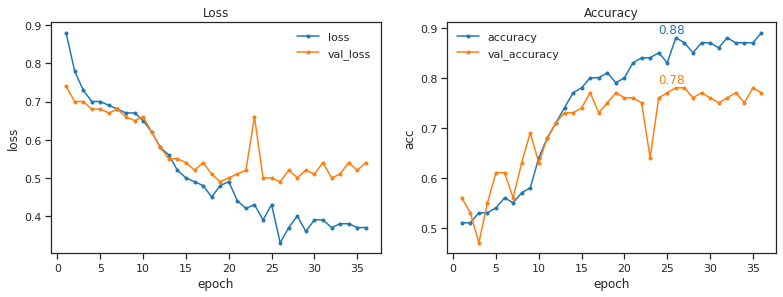

In [96]:
plot_history(history, 
             horizontal=2, 
             vertical_train=-0.01, vertical_val=-0.01)
# epoch 26

In [97]:
f.plot_metrics(model, X_test, y_test)

Acc: 0.78
Precision: 0.74
Recall: 0.79
F1: 0.76
Conf. Matrix: 
[[259  77]
 [ 58 219]]


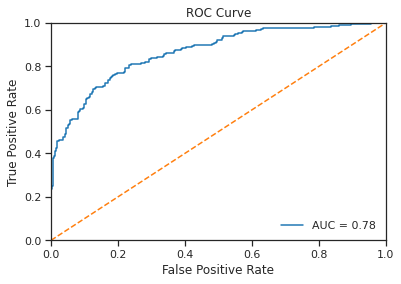

AUC: 0.7807


In [98]:
f.get_roc_curve(model, X_test, y_test)